Introduction

In this post, I’ll summarize the exploratory data analyses I performed, explain the feature engineering and reduction steps I utilized, and present my final models to classify tweets feed

Problem Statement
The goal of this project was to classify twitter feeds into breakfast time, lunch time or dinner time, using only features derived from text from ten news organizations

Risks and Assumptions
I’ve chosen my source based on some renown news organizations and large corpus, but I recognize that this model may not generalize to news from other sources. My results will likely also be applicable to my determined timeframe, and a time interval since I’m utilizing tweets from October 2017 onwards.



In [2]:
import twitter, re, datetime, pandas as pd, numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import textblob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,AdaBoostRegressor,RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVC

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [39]:
import twitter, re, datetime, pandas as pd

# your keys go here:
twitter_keys = {
    'consumer_key':        'c2OWXk5ysfZHebnj7YQcKeVtR',
    'consumer_secret':     'qECxF7fUrC0AFi4Ib7ye4dXlqFcJxbADox4z5xh9CSuRWbYugA',
    'access_token_key':    '930174555032825862-cg1AJLOXuE61kTxYtrcwPN53czHhNby',
    'access_token_secret': '4fRMZkII1IeZGY8VDEFqKuO12SDmtHEfj4aqnGJHCdG7Y'
}

api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret']
)

In [58]:
class TweetMiner(object):

    result_limit    =   20    
    api             =   False
    data            =   []
    
    def __init__(self, keys_dict, api, result_limit = 20):
        
        self.api = api
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit
        

    def mine_user_tweets(self, user="GA", mine_rewteets=False, max_pages=1, max_id=None):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=max_id)        
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=max_id)
                
            for item in statuses:

                mined = {
                'tweet_id': item.id,
                'handle': item.user.name,
                'retweet_count': item.retweet_count,
                'text': item.text,
                'mined_at': datetime.datetime.now(),
                'created_at': item.created_at,
                'geo' : item.geo,
                'place' : item.place,
            }
            
                
                last_tweet_id = item.id
                data.append(mined)
                
            page += 1
            
        return data

In [59]:
miner = TweetMiner(keys_dict = twitter_keys, api = api, result_limit=200) 

In [60]:
cnn_tweets = miner.mine_user_tweets(user='CNN')
cnn_df2= pd.DataFrame(cnn_tweets)
cnn_df2

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id
0,Mon Dec 18 21:57:27 +0000 2017,None,CNN,2017-12-18 16:59:35.712906,None,33,"""I'm concerned that no job is safe in the Trum...",942876488092839936
1,Mon Dec 18 21:52:08 +0000 2017,None,CNN,2017-12-18 16:59:35.712916,None,41,"Matthew Petersen wrote that he is ""no stranger...",942875149782659072
2,Mon Dec 18 21:38:21 +0000 2017,None,CNN,2017-12-18 16:59:35.712919,None,946,Former Director of National Intelligence James...,942871683152560128
3,Mon Dec 18 21:31:55 +0000 2017,None,CNN,2017-12-18 16:59:35.712921,None,69,The power is back on at Atlanta's Hartsfield-J...,942870062322667525
4,Mon Dec 18 21:25:50 +0000 2017,None,CNN,2017-12-18 16:59:35.712923,None,81,Pierce County Sheriff’s Office spokesman Ed Tr...,942868532374769664
5,Mon Dec 18 21:17:48 +0000 2017,None,CNN,2017-12-18 16:59:35.712925,None,54,"Washington Rep. Dennis Heck: ""There's no quest...",942866511680610304
6,Mon Dec 18 21:11:50 +0000 2017,None,CNN,2017-12-18 16:59:35.712927,None,60,President Trump's first tweet on the train cra...,942865009356558338
7,Mon Dec 18 21:03:40 +0000 2017,None,CNN,2017-12-18 16:59:35.712929,None,87,Positive Train Control technology that slows t...,942862953673609220
8,Mon Dec 18 20:47:55 +0000 2017,None,CNN,2017-12-18 16:59:35.712931,None,139,"""It was absolutely unreal, not what we were ex...",942858991000080385
9,Mon Dec 18 20:43:29 +0000 2017,None,CNN,2017-12-18 16:59:35.712934,None,107,"""We had to have only missed it by a couple of ...",942857873872207872


In [61]:
cnn_df2.drop_duplicates('text').shape

(200, 8)

In [ ]:
cnn

In [62]:
newmaxid = 722382636307271682

In [67]:
for _ in range(0,30):
    w_tweets = miner.mine_user_tweets(user='CNN',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    cnn_df  = pd.concat([cnn_df, w_dfx])
    newmaxid =  cnn_df.tweet_id.min() - 1

In [64]:
cnn_df.drop_duplicates('text').shape

(3217, 8)

In [68]:
cnn_df.shape

(11217, 8)

In [52]:
cnn_df.iloc[3198:3202,:]

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id
198,Wed Dec 13 03:47:40 +0000 2017,None,CNN,2017-12-18 16:36:15.804167,None,819,"Bakari Sellers: ""The raw emotion of victory on...",940790298950754305
199,Wed Dec 13 03:42:31 +0000 2017,None,CNN,2017-12-18 16:36:15.804169,None,576,"What you need to know about Doug Jones, the De...",940788999312076801
200,Thu Dec 14 08:29:43 +0000 2017,None,CNN,2017-12-18 16:36:16.311747,None,120,An embattled Kentucky state lawmaker facing se...,941223664363753477
201,Thu Dec 14 08:19:24 +0000 2017,None,CNN,2017-12-18 16:36:16.311763,None,150,"These smart, self-driving buses are being test...",941221070765510656


In [54]:
cnn_df.iloc[3998:4002,:]

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id
998,Wed Dec 13 03:47:40 +0000 2017,None,CNN,2017-12-18 16:36:17.953802,None,819,"Bakari Sellers: ""The raw emotion of victory on...",940790298950754305
999,Wed Dec 13 03:42:31 +0000 2017,None,CNN,2017-12-18 16:36:17.953804,None,576,"What you need to know about Doug Jones, the De...",940788999312076801
0,Wed Dec 13 03:32:08 +0000 2017,None,CNN,2017-12-18 16:36:18.315536,None,2802,Democrat Doug Jones will win the Senate specia...,940786387158224896
1,Wed Dec 13 03:29:34 +0000 2017,None,CNN,2017-12-18 16:36:18.315545,None,108,"This ancient penguin was about 5'10"" and weigh...",940785741176737792


In [53]:
cnn_df.iloc[4198:4202,:]

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id
198,Tue Dec 12 03:23:21 +0000 2017,None,CNN,2017-12-18 16:36:18.315878,None,2068,Former NBA player Charles Barkley reacts to Ka...,940421790811037696
199,Tue Dec 12 03:21:05 +0000 2017,None,CNN,2017-12-18 16:36:18.315879,None,104,Comcast is dropping out of the running to buy ...,940421219119259648
200,Wed Dec 13 03:32:08 +0000 2017,None,CNN,2017-12-18 16:36:18.695219,None,2802,Democrat Doug Jones will win the Senate specia...,940786387158224896
201,Wed Dec 13 03:29:34 +0000 2017,None,CNN,2017-12-18 16:36:18.695231,None,108,"This ancient penguin was about 5'10"" and weigh...",940785741176737792


In [49]:
cnn_df.iloc[1998:2002,:]

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id
998,Fri Dec 15 14:50:47 +0000 2017,None,CNN,2017-12-18 16:36:12.704156,None,52,How Mueller's path was muddied in two weeks ht...,941681950032580609
999,Fri Dec 15 14:46:13 +0000 2017,None,CNN,2017-12-18 16:36:12.704158,None,456,President Trump on the FBI: “It’s a shame what...,941680801598472192
0,Fri Dec 15 14:35:07 +0000 2017,None,CNN,2017-12-18 16:36:12.997793,None,91,"Omarosa Manigault Newman, a senior staffer who...",941678009995718657
1,Fri Dec 15 14:26:19 +0000 2017,None,CNN,2017-12-18 16:36:12.997804,None,237,"RT @cnni: CNN's @arwaCNN is in Al-Bireh, West ...",941675795554164738


In [46]:
cnn_df.drop_duplicates('text').shape

(2000, 8)

In [118]:
fox_tweets = miner.mine_user_tweets(user='FoxNews')
fox_df= pd.DataFrame(fox_tweets)
fox_df

In [55]:
newmaxid2 = 942537821331640326

In [59]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='FoxNews',max_id=newmaxid2)
    w_dfx = pd.DataFrame(w_tweets)
    FOX_tweet = pd.concat([fox_df, w_dfx])
    newmaxid2 = FOX_tweet.tweet_id.min() - 1

In [119]:
wsbtv_tweets = miner.mine_user_tweets(user='wsbtv')
wsbtv_df= pd.DataFrame(wsbtv_tweets)
wsbtv_df

In [52]:
newmaxid =942588026135465984

In [ ]:
WSBTV_tweet

In [64]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='wsbtv',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    WSBTV_tweet = pd.concat([wsbtv_df, w_dfx])
    newmaxid = WSBTV_tweet.tweet_id.min() - 1

In [120]:
wapo_tweets = miner.mine_user_tweets(user='washingtonpost')
wapo_df= pd.DataFrame(wapo_tweets)
wapo_df

In [72]:
newmaxid =941824495664242688

In [73]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='washingtonpost',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    WaPo_tweet = pd.concat([wapo_df, w_dfx])
    newmaxid = WaPo_tweet.tweet_id.min() - 1

In [121]:
#WaPo_tweet

In [122]:
#WaPo_tweet.drop_duplicates('text').shape

In [123]:
nytimes_tweet = miner.mine_user_tweets(user='nytimes')
nytimes_df= pd.DataFrame( nytimes_tweet)
nytimes_df

In [77]:
newmaxid =942153109895180288

In [ ]:
nytimes_tweet

In [80]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='nytimes',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    nytimes_tweet = pd.concat([nytimes_df, w_dfx])
    newmaxid =nytimes_tweet.tweet_id.min() - 1

In [124]:
# nytimes_tweet

In [ ]:
nytimes_tweet.shape

In [82]:
nytimes_tweet.drop_duplicates('text').shape

(2398, 8)

In [125]:
cbs_tweet = miner.mine_user_tweets(user='cbstweet')
cbs_df= pd.DataFrame(cbs_tweet)
cbs_df

In [84]:
newmaxid = 936294275947679745

In [87]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='cbstweet',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    cbs_tweet = pd.concat([cbs_df, w_dfx])
    newmaxid =cbs_tweet.tweet_id.min() - 1

In [126]:
#cbs_tweet

In [ ]:
cbs_tweet.shape

In [127]:
#cbs_tweet.drop_duplicates('text').shape

In [128]:
abc_tweet = miner.mine_user_tweets(user='ABC')
abc_df= pd.DataFrame(abc_tweet)
abc_df

In [ ]:
ABC_tweet

In [92]:
newmaxid = 941856130560593921

In [94]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='ABC',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    ABC_tweet = pd.concat([abc_df, w_dfx])
    newmaxid =ABC_tweet.tweet_id.min() - 1

In [95]:
ABC_tweet.shape

(12000, 8)

In [129]:
msnbc_tweet = miner.mine_user_tweets(user='MSNBC')
msnbc_df= pd.DataFrame(msnbc_tweet)
msnbc_df

In [100]:
newmaxid = 941193580135309317

In [101]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='MSNBC',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    MSNBC_tweet = pd.concat([msnbc_df, w_dfx])
    newmaxid =MSNBC_tweet.tweet_id.min() - 1

In [102]:
MSNBC_tweet.shape

(12000, 8)

In [130]:
BuzzFeedNews_tweet = miner.mine_user_tweets(user='BuzzFeedNews')
BuzzFeedNews_df= pd.DataFrame(BuzzFeedNews_tweet)
BuzzFeedNews_df

In [106]:
newmaxid = 941693222086152192

In [108]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='BuzzFeedNews',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    BuzzFeedNews_tweet = pd.concat([BuzzFeedNews_df, w_dfx])
    newmaxid =BuzzFeedNews_tweet.tweet_id.min() - 1

In [109]:
BuzzFeedNews_tweet.shape

(12000, 8)

In [131]:
NPR_tweet = miner.mine_user_tweets(user='MNPR')
NPR_df= pd.DataFrame(NPR_tweet)
NPR_df

In [112]:
newmaxid = 926528673183944705

In [114]:
for _ in range(0,10):
    w_tweets = miner.mine_user_tweets(user='MNPR',max_id=newmaxid)
    w_dfx = pd.DataFrame(w_tweets)
    NPR_tweet = pd.concat([NPR_df, w_dfx])
    newmaxid =NPR_tweet.tweet_id.min() - 1

In [115]:
NPR_tweet.shape

(11940, 8)

In [ ]:
twitter= pd.concat((CNN_tweet,FOX_tweet,WSBTV_tweet,WaPo_tweet,nytimes_tweet,cbs_tweet,ABC_tweet,MSNBC_tweet,BuzzFeedNews_tweet,NPR_tweet),axis=0)

In [ ]:
twitter.shape

In [ ]:
twitter.to_csv('twitter.csv',index=False)

In [5]:
twitter = pd.read_csv('twitter.csv')

In [6]:
twitter.shape

(116051, 8)

In [7]:
twitter2 = twitter.copy()

In [8]:
import os
import re
import csv
import sys
# In this next script, we’ll first clean up our dirty data, get rid of emoticons, hashtags, RT’s, ?, http, etc.
def process_text2(tweets):
        """Remove emoticons, numbers etc. and returns list of cleaned tweets."""
        stripped_text = [
        re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?" +
               sys.argv[1].lower(), '',
               tweets.lower()).strip()
    ]
        return stripped_text[0]


#process_text2(df2.loc[2, 'text'])

twitter2['Text'] =twitter2['text'].apply(process_text2) 

In [9]:
def remove_stop_words(tweets):
    """Remove stop words in tweets."""
    from nltk.corpus import stopwords
    stop = stopwords.words('english') 
    # If our word is not in the stop list then we add it to our word list
    clean_text = ' '.join([word for word in tweets.split(' ')
                           if word not in stop])
    return clean_text

twitter2['Text'] =twitter2['Text'].apply(remove_stop_words) 

In [10]:
twitter2.head(2)

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id,Text
0,Thu Dec 14 23:50:41 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317226,NaN,3,The House Intelligence Committee plans to hold...,941455435726548992,house intelligence committee plans hold two of...
1,Thu Dec 14 23:46:04 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317236,NaN,24,21st Century Fox executive co-chairman Rupert ...,941454273711308800,21st century fox executive cochairman rupert m...


In [11]:
twitter2=twitter2.drop_duplicates('Text')

In [12]:
twitter2.shape

(22742, 9)

In [13]:
def time(cell):
    if 6 <=int(cell[11:13]) < 11:
        return 'breakfast'
    elif 11 <=int(cell[11:13])< 14:
        return 'lunchtime'
    elif 19 <=int(cell[11:13])< 21:
        return 'dinnertime'
    else:
        return 'N/A'
    
twitter2['Time'] =twitter2['created_at'].apply(time)

In [14]:
def time2(cell):
    if cell =='breakfast':
        return 1
    elif cell =='lunchtime':
        return 2
    elif cell =='dinnertime':
        return 3
    else:
        return 4
    

In [15]:
twitter2['numeric_time']=twitter2['Time'].apply(time2)

In [16]:
twitter2.head(2)

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id,Text,Time,numeric_time
0,Thu Dec 14 23:50:41 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317226,NaN,3,The House Intelligence Committee plans to hold...,941455435726548992,house intelligence committee plans hold two of...,N/A,4
1,Thu Dec 14 23:46:04 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317236,NaN,24,21st Century Fox executive co-chairman Rupert ...,941454273711308800,21st century fox executive cochairman rupert m...,N/A,4


In [18]:
twitter2.numeric_time.value_counts()

4    15451
3     2618
2     2453
1     2220
Name: numeric_time, dtype: int64

In [19]:
twitter2.head(2)

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id,Text,Time,numeric_time
0,Thu Dec 14 23:50:41 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317226,NaN,3,The House Intelligence Committee plans to hold...,941455435726548992,house intelligence committee plans hold two of...,N/A,4
1,Thu Dec 14 23:46:04 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317236,NaN,24,21st Century Fox executive co-chairman Rupert ...,941454273711308800,21st century fox executive cochairman rupert m...,N/A,4


In [20]:
twitter2.handle.value_counts()

CBS Tweet             2776
Washington Post       2714
MSNBC                 2694
BuzzFeed News         2652
ABC News              2271
Fox News              2202
CNN                   2154
WSB-TV                2111
MNPR | Ryan May       2042
The New York Times    1126
Name: handle, dtype: int64

In [21]:
# engineering sentiment features for analysis
from textblob import TextBlob
def add_sub_and_pol(df):
    df=df.copy()
    def polarity(text):
        text = TextBlob(text)
        return text.sentiment.polarity
    
    def subjectivity(text):
        text = TextBlob(text)
        return text.sentiment.subjectivity
    
    def get_tweet_sentiment(text):
        text = TextBlob(text)
        if text.sentiment.polarity > 0:
            return 'positive'
        elif text.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
    twitter2['subjectivity'] =twitter2['Text'].apply(subjectivity)
    twitter2['polarity'] =twitter2['Text'].apply(polarity)
    twitter2['sentiment'] =twitter2['Text'].apply(get_tweet_sentiment)
    return twitter2.copy()

In [22]:
twitter2=add_sub_and_pol(twitter2)

In [23]:
twitter2.head(2)

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id,Text,Time,numeric_time,subjectivity,polarity,sentiment
0,Thu Dec 14 23:50:41 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317226,NaN,3,The House Intelligence Committee plans to hold...,941455435726548992,house intelligence committee plans hold two of...,N/A,4,0.227273,0.068182,positive
1,Thu Dec 14 23:46:04 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317236,NaN,24,21st Century Fox executive co-chairman Rupert ...,941454273711308800,21st century fox executive cochairman rupert m...,N/A,4,0.311111,0.166667,positive


In [3]:
twitter2.to_csv('twitter2.csv', index=False)

In [4]:
twitter2 = pd.read_csv('twitter2.csv')

In [4]:
twitter2.Text.isnull().sum()

1

### Sentiment analysis

In [25]:
print('CBS happiness:',twitter2.loc[twitter2['handle'].str.contains('CBS Tweet'),'polarity'].mean())

print('WAPO happiness:', twitter2.loc[twitter2['handle'].str.contains('Washington Post'),'polarity'].mean())

print('MSNBC happiness:', twitter2.loc[twitter2['handle'].str.contains('MSNBC'),'polarity'].mean())

print('BuzzFeed happiness:', twitter2.loc[twitter2['handle'].str.contains('BuzzFeed News'),'polarity'].mean())

print('ABC happiness:',twitter2.loc[twitter2['handle'].str.contains('ABC News'),'polarity'].mean())

print('Fox News happiness:', twitter2.loc[twitter2['handle'].str.contains('Fox News'),'polarity'].mean())

print('CNN happiness:', twitter2.loc[twitter2['handle'].str.contains('CNN'),'polarity'].mean())

print('WSB-TV happiness:',twitter2.loc[twitter2['handle'].str.contains('WSB-TV'),'polarity'].mean())

print('NPR happiness:', twitter2.loc[twitter2['handle'].str.contains('MNPR'),'polarity'].mean())

print('NyTimes happiness:', twitter2.loc[twitter2['handle'].str.contains('New York Times'),'polarity'].mean())

CBS happiness: 0.13648128540194446
WAPO happiness: 0.038072295447940184
MSNBC happiness: 0.0274204782473156
BuzzFeed happiness: 0.061330908172395594
ABC happiness: 0.06952404943345047
Fox News happiness: 0.04060534536862883
CNN happiness: 0.04345570488995506
WSB-TV happiness: 0.07517961941605923
NPR happiness: 0.09602517438034038
NyTimes happiness: 0.08178945554889148


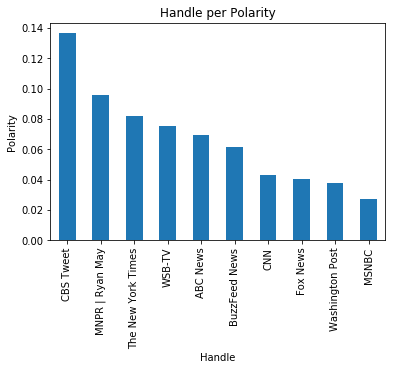

In [21]:
twitter2.groupby('handle')['polarity'].mean().sort_values(ascending=False).plot(kind='bar',title='Handle per Polarity')
plt.xlabel('Handle')
plt.ylabel('Polarity');

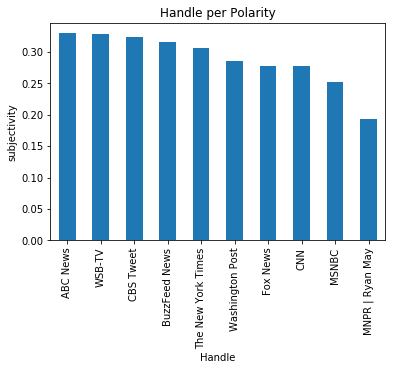

In [22]:
twitter2.groupby('handle')['subjectivity'].mean().sort_values(ascending=False).plot(kind='bar',title='Handle per Polarity')
plt.xlabel('Handle')
plt.ylabel('subjectivity');

In [77]:
list(twitter2.handle.value_counts().index)

Index(['CBS Tweet', 'Washington Post', 'MSNBC', 'BuzzFeed News', 'ABC News',
       'Fox News', 'CNN', 'WSB-TV', 'MNPR | Ryan May', 'The New York Times'],
      dtype='object')

In [82]:
order_of_polarity = list(twitter2.groupby('handle')['polarity'].mean().sort_values(ascending=False).index)

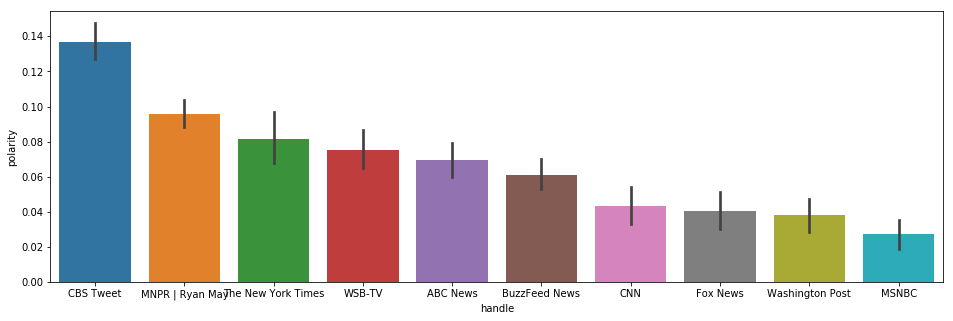

In [84]:
fig, ax = plt.subplots(figsize = (16, 5))
sns.barplot(x = 'handle', y = 'polarity',order=order_of_polarity, data = twitter2, ax = ax)
plt.show()

In [96]:
order_of_subjectivity = list(twitter2.groupby('handle')['subjectivity'].mean().sort_values(ascending=False).index)

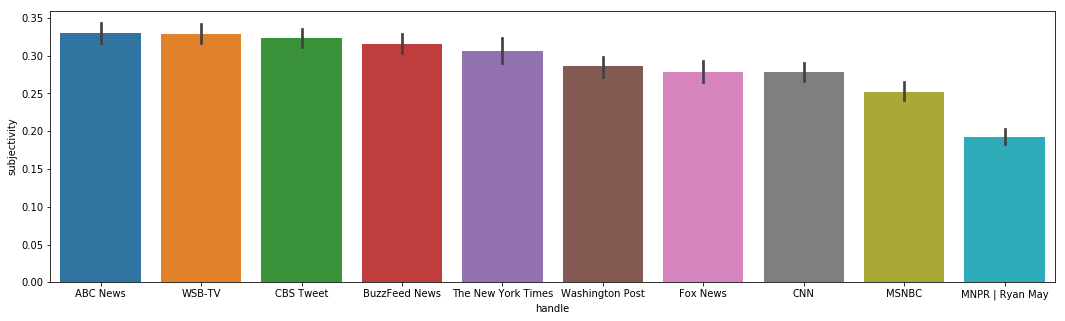

In [98]:
fig, ax = plt.subplots(figsize = (18, 5))
sns.barplot(x = 'handle', y = 'subjectivity',order=order_of_subjectivity, data = twitter2, ax = ax)
plt.show()

In [88]:
df_breakfast = twitter2.loc[twitter2['numeric_time']==1,:]
df_lunch =  twitter2.loc[twitter2['numeric_time']==2,:]
df_dinner =  twitter2.loc[twitter2['numeric_time']==3,:]

In [89]:
dic = {
 'breakfast': list(df_breakfast.iloc[:2000,:].loc[:,'polarity']),
 'lunch' : list(df_lunch.iloc[:2000,:].loc[:,'polarity']),
 'dinner': list(df_dinner.iloc[:2000,:].loc[:,'polarity'])
}


In [90]:
classes = pd.DataFrame(dic)

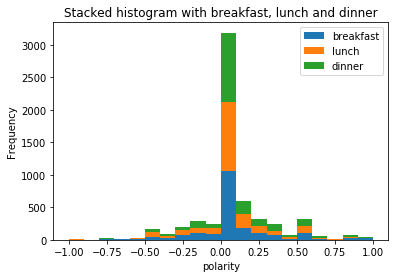

In [92]:
classes[['breakfast','lunch','dinner']].plot.hist(bins=20,stacked=True)
plt.title('Stacked histogram with breakfast, lunch and dinner')
plt.xlabel('polarity')
plt.ylabel('Frequency')

In [ ]:
# As we can see, my classes overlap

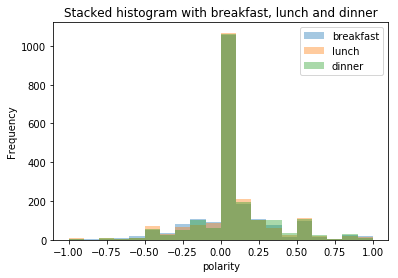

In [93]:
classes[['breakfast','lunch','dinner']].plot.hist(bins=20,alpha=0.4)
plt.title('Stacked histogram with breakfast, lunch and dinner')
plt.xlabel('polarity')
plt.ylabel('Frequency')

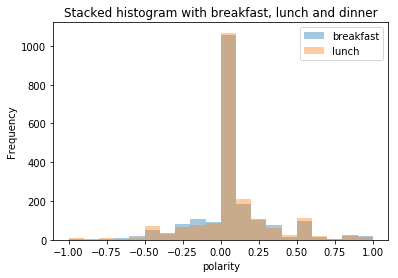

In [95]:
classes[['breakfast','lunch']].plot.hist(bins=20,alpha=0.4)
plt.title('Stacked histogram with breakfast, lunch and dinner')
plt.xlabel('polarity')
plt.ylabel('Frequency')

In [ ]:
# My classes are very similar

### Build a model with pymc3 to estimate the difference in tone between breakfast and lunchtime tweets

In [ ]:
# The null hypothesis is that there is zero difference between the mean of two groups.
# The alternative hypothesis is that there IS a difference.

# in this MCMC simulation, I will estimate how different  two groups are in terms of polarity

In [25]:
import pymc3 as pm

Couldn't import dot_parser, loading of dot files will not be possible.


In [ ]:
# I will be using Bayesian posterior estimation to look at the difference in breakfast_tweets and lunchtime_tweets .

In [26]:
breakfast_tweets_tone= twitter2.loc[twitter2['numeric_time']==1,'polarity'].values
lunchtime_tweets_tone = twitter2.loc[twitter2['numeric_time']==2,'polarity'].values

print(breakfast_tweets_tone.mean(),lunchtime_tweets_tone.mean() )

0.0513992537993 0.0521692336404


In [27]:
prior_mean = twitter2.polarity.mean()
prior_std = twitter2.polarity.std()
print(prior_mean, prior_std)

0.06624346054485264 0.24614381784910266


In [28]:
with pm.Model() as model:
    
    breakfast_tweets_tone_mean = pm.Normal('breakfast_tweets_tone_mean', prior_mean, sd=prior_std)
    lunchtime_tweets_tone_mean = pm.Normal('lunchtime_tweets_tone_mean', prior_mean, sd=prior_std)
    
    breakfast_tweets_tone_std = pm.Gamma('breakfast_tweets_tone_std', mu=prior_std, sd=prior_std)
    lunchtime_tweets_tone_std = pm.Gamma('lunchtime_tweets_tone_std', mu=prior_std, sd=prior_std)
    
    breakfast_tweets_polarity = pm.Normal('breakfast_tweets_polarity', mu=breakfast_tweets_tone_mean, sd=breakfast_tweets_tone_std, observed=breakfast_tweets_tone)
    lunchtime_tweets_polarity = pm.Normal('lunchtime_tweets_polarity', mu=lunchtime_tweets_tone_mean, sd=lunchtime_tweets_tone_std, observed=lunchtime_tweets_tone)
    
    mean_delta = pm.Deterministic('mean_delta', breakfast_tweets_tone_mean - lunchtime_tweets_tone_mean)
    std_delta = pm.Deterministic('std_delta',  breakfast_tweets_tone_std - lunchtime_tweets_tone_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((breakfast_tweets_tone_std**2 + lunchtime_tweets_tone_std**2)/2.))

In [29]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=2)

logp = -109.97, ||grad|| = 0.00044465: 100%|██████████| 12/12 [00:00<00:00, 19.10it/s]  
100%|██████████| 50500/50500 [01:48<00:00, 463.49it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c166ec4e0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a0fb2a390>], dtype=object)

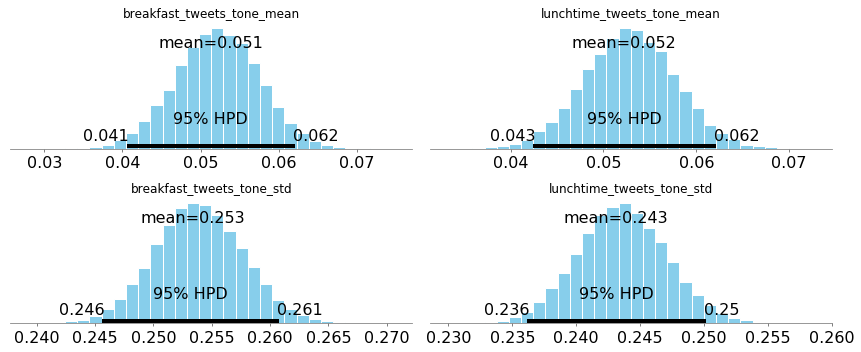

In [30]:
pm.plot_posterior(trace[5000::3],
                  varnames=['breakfast_tweets_tone_mean', 'lunchtime_tweets_tone_mean',
                            'breakfast_tweets_tone_std', 'lunchtime_tweets_tone_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1106cef0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c1ecc9eb8>], dtype=object)

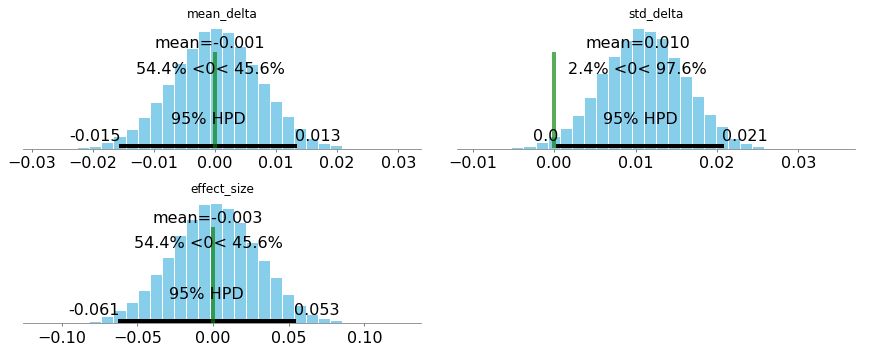

In [31]:
pm.plot_posterior(trace[5000::3],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0)

In [ ]:
# The Plot of the posteriors of our metric distributions shows that there is NOT A difference in the mean, therefore the
# the two groups are the same 

### Build a model with pymc3 to estimate the difference in tone between breakfast and dinnertime tweets

In [32]:
breakfast_tweets_tone= twitter2.loc[twitter2['numeric_time']==1,'polarity'].values
dinnertime_tweets_tone = twitter2.loc[twitter2['numeric_time']==3,'polarity'].values

print(breakfast_tweets_tone.mean(),dinnertime_tweets_tone.mean() )

0.0513992537993 0.0753901143261


In [33]:
prior_mean2 = twitter2.polarity.mean()
prior_std2 = twitter2.polarity.std()
print(prior_mean2, prior_std2)

0.06624346054485264 0.24614381784910266


In [34]:
with pm.Model() as model:
    
    breakfast_tweets_tone_mean = pm.Normal('breakfast_tweets_tone_mean', prior_mean2, sd=prior_std2)
    dinnertime_tweets_tone_mean = pm.Normal('dinnertime_tweets_tone_mean', prior_mean2, sd=prior_std2)
    
    breakfast_tweets_tone_std = pm.Gamma('breakfast_tweets_tone_std', mu=prior_std2, sd=prior_std2)
    dinnertime_tweets_tone_std = pm.Gamma('dinnertime_tweets_tone_std', mu=prior_std2, sd=prior_std2)
    
    breakfast_tweets_polarity = pm.Normal('breakfast_tweets_polarity', mu=breakfast_tweets_tone_mean, sd=breakfast_tweets_tone_std, observed=breakfast_tweets_tone)
    dinnertime_tweets_polarity = pm.Normal('dinnertime_tweets_polarity', mu=dinnertime_tweets_tone_mean, sd=dinnertime_tweets_tone_std, observed=dinnertime_tweets_tone)
    
    mean_delta = pm.Deterministic('mean_delta', breakfast_tweets_tone_mean - dinnertime_tweets_tone_mean)
    std_delta = pm.Deterministic('std_delta',  breakfast_tweets_tone_std - dinnertime_tweets_tone_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((breakfast_tweets_tone_std**2 + dinnertime_tweets_tone_std**2)/2.))

In [35]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=2)

logp = -136.95, ||grad|| = 0.098478: 100%|██████████| 13/13 [00:00<00:00, 620.32it/s]  
100%|██████████| 50500/50500 [01:53<00:00, 443.98it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c16174f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c15dbb0b8>], dtype=object)

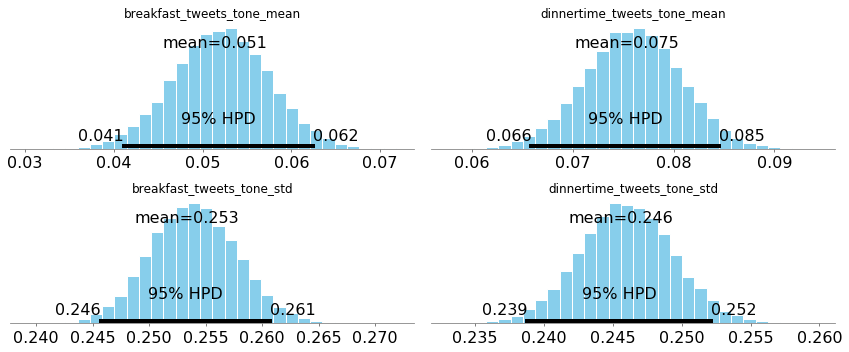

In [36]:
pm.plot_posterior(trace[5000::3],
                  varnames=['breakfast_tweets_tone_mean', 'dinnertime_tweets_tone_mean',
                            'breakfast_tweets_tone_std', 'dinnertime_tweets_tone_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c213dbcf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c213fb438>], dtype=object)

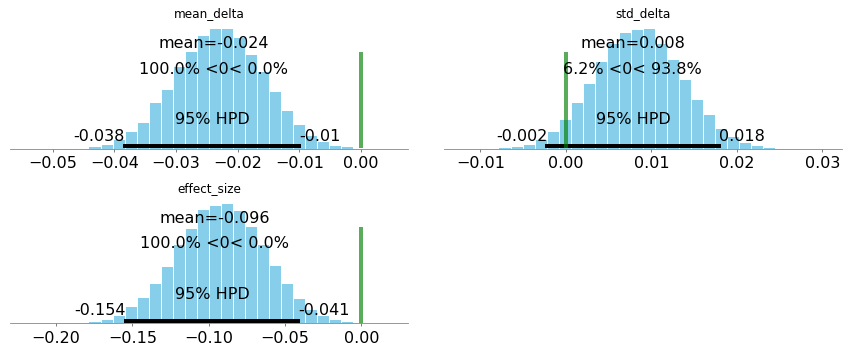

In [37]:
pm.plot_posterior(trace[5000::3],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0)

In [ ]:
# The Plot of the posteriors of our metric distributions shows that there is A difference in the mean, therefore the
# two groups are different

### Build a model with pymc3 to estimate the difference in tone between lunchtime and dinnertime tweets

In [38]:
lunchtime_tweets_tone= twitter2.loc[twitter2['numeric_time']==2,'polarity'].values
dinnertime_tweets_tone = twitter2.loc[twitter2['numeric_time']==3,'polarity'].values

print(lunchtime_tweets_tone.mean(),dinnertime_tweets_tone.mean() )

0.0521692336404 0.0753901143261


In [39]:
prior_mean3 = twitter2.polarity.mean()
prior_std3 = twitter2.polarity.std()
print(prior_mean3, prior_std3)

0.06624346054485264 0.24614381784910266


In [40]:
with pm.Model() as model:
    
    lunchtime_tweets_tone_mean = pm.Normal('lunchtime_tweets_tone_mean', prior_mean3, sd=prior_std3)
    dinnertime_tweets_tone_mean = pm.Normal('dinnertime_tweets_tone_mean', prior_mean3, sd=prior_std3)
    
    lunchtime_tweets_tone_std = pm.Gamma('lunchtime_tweets_tone_std', mu=prior_std3, sd=prior_std3)
    dinnertime_tweets_tone_std = pm.Gamma('dinnertime_tweets_tone_std', mu=prior_std3, sd=prior_std3)
    
    lunchtime_tweets_polarity = pm.Normal('lunchtime_tweets_polarity', mu=lunchtime_tweets_tone_mean, sd=lunchtime_tweets_tone_std, observed=lunchtime_tweets_tone)
    dinnertime_tweets_polarity = pm.Normal('dinnertime_tweets_polarity', mu=dinnertime_tweets_tone_mean, sd=dinnertime_tweets_tone_std, observed=dinnertime_tweets_tone)
    
    mean_delta = pm.Deterministic('mean_delta', lunchtime_tweets_tone_mean - dinnertime_tweets_tone_mean)
    std_delta = pm.Deterministic('std_delta',  lunchtime_tweets_tone_std - dinnertime_tweets_tone_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((lunchtime_tweets_tone_std**2 + dinnertime_tweets_tone_std**2)/2.))

In [41]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=2)

logp = -46.215, ||grad|| = 0.073468: 100%|██████████| 14/14 [00:00<00:00, 650.65it/s]  
100%|██████████| 50500/50500 [01:56<00:00, 434.47it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c206c1dd8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c206400f0>], dtype=object)

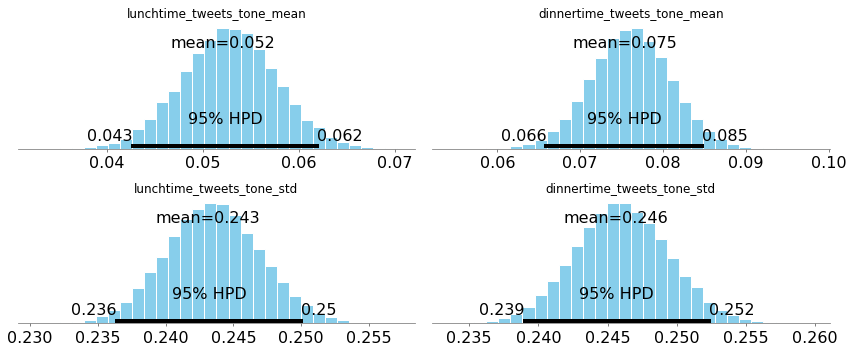

In [42]:
pm.plot_posterior(trace[5000::3],
                  varnames=['lunchtime_tweets_tone_mean', 'dinnertime_tweets_tone_mean',
                            'lunchtime_tweets_tone_std', 'dinnertime_tweets_tone_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20a5fe80>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c218315c0>], dtype=object)

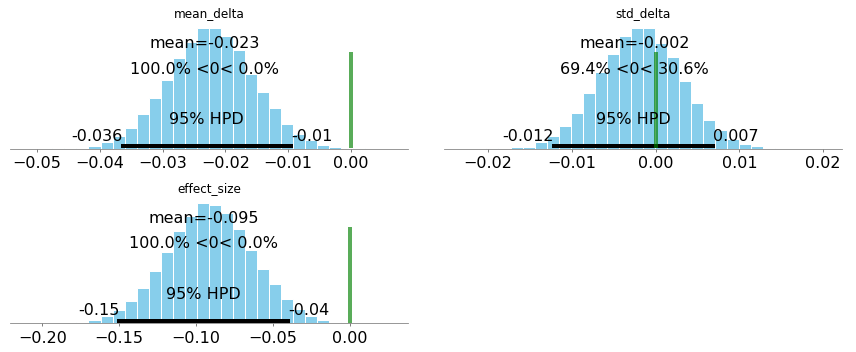

In [43]:
pm.plot_posterior(trace[5000::3],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0)

In [ ]:
# The Plot of the posteriors of our metric distributions shows that there is A difference in the mean, therefore the
# two groups are different

In [44]:
pm.summary(trace[5000:],varnames=['mean_delta','std_delta','effect_size'])


mean_delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.023           0.007            0.000            [-0.037, -0.010]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.037         -0.028         -0.023         -0.019         -0.010


std_delta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.002           0.005            0.000            [-0.012, 0.007]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.012         -0.006         -0.002         0.001          0.007


effect_size:

  Mean             SD               MC Error         95% HPD interval
  ------

 ### Use LDA to identify topics in the tweets

In [45]:
from sklearn.decomposition import LatentDirichletAllocation

In [46]:
cv = CountVectorizer(stop_words='english')
cv.fit(twitter2['Text'].values)
X = cv.transform(twitter2['Text'].values)
X

<22742x23919 sparse matrix of type '<class 'numpy.int64'>'
	with 200031 stored elements in Compressed Sparse Row format>

In [47]:
feature_names = cv.get_feature_names()
lda = LatentDirichletAllocation(n_components=10)

lda.fit(X)

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [48]:
print(lda.components_.shape)

(10, 23919)


In [49]:
results = pd.DataFrame(lda.components_,
                      columns=feature_names)

In [50]:
for topic in range(10):
    print('Topic', topic)
    word_list = results.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')

Topic 0
sexual cbs women allegations harassment dont think opinion accused misconduct work going group love times theres amid thats died access taking things perspective game assault 

Topic 1
mnpr latest public thanks daily jerusalem https right need national security coming trump tonights exclusive left thanksgiving follow wants 2018 major massive use got political 

Topic 2
trump house watch news white blog flynn breaking woman says star michael night time make im president great congress live guilty trumps deal decision end 

Topic 3
year social snow st look 2017 like season world reports set puerto tv rico cbsratingnews states fans history facebook united moment charges kids air storm 

Topic 4
trump president communications trumps special says intern manager election john travel pr mueller analysis donald power calls conyers digital investigation russian federal party hiring sanders 

Topic 5
tonight minnesota marketing live mn specialist new report best story franken al today he

The topics talked sexual harassment, russia investigation, and election 

### Multiclass Classification Model Building

In [13]:
df_breakfast = twitter2.loc[twitter2['numeric_time']==1,:]
df_lunch =  twitter2.loc[twitter2['numeric_time']==2,:]
df_dinner =  twitter2.loc[twitter2['numeric_time']==3,:]

In [17]:
# # the baseline
# y_test.value_counts()/len(y_test)

In [7]:
twitter2.head(2)

,created_at,geo,handle,mined_at,place,retweet_count,text,tweet_id,Text,Time,numeric_time,subjectivity,polarity,sentiment
0,Thu Dec 14 23:50:41 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317226,NaN,3,The House Intelligence Committee plans to hold...,941455435726548992,house intelligence committee plans hold two of...,NaN,4,0.227273,0.068182,positive
1,Thu Dec 14 23:46:04 +0000 2017,NaN,CNN,2017-12-14 18:51:13.317236,NaN,24,21st Century Fox executive co-chairman Rupert ...,941454273711308800,21st century fox executive cochairman rupert m...,NaN,4,0.311111,0.166667,positive


In [8]:
twitter2.Text.isnull().sum()

1

In [6]:
model_df =twitter2.loc[twitter2['numeric_time'] !=4,:]

In [11]:
model_df.isnull().sum()

created_at          0
geo              7291
handle              0
mined_at            0
place            7291
retweet_count       0
text                0
tweet_id            0
Text                1
Time                0
numeric_time        0
subjectivity        0
polarity            0
sentiment           0
dtype: int64

In [7]:
model_df =model_df.drop(['geo','place'],axis = 1).copy()

In [8]:
model_df = model_df.dropna()

In [9]:
X = model_df['Text']
y= model_df['numeric_time']

In [10]:
y.shape

(7290,)

### Naive bayes models

In [22]:
from sklearn.naive_bayes import MultinomialNB
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
df_X_train = pd.DataFrame(X_train.todense(), columns=tfidf.get_feature_names())

In [24]:
ypreds = mnb.predict(X_test)

In [25]:
conmat_1 = confusion_matrix(y_test, ypreds, labels=mnb.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=mnb.classes_, index=mnb.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.494240263302
             precision    recall  f1-score   support

          1       0.47      0.32      0.38       554
          2       0.44      0.52      0.48       581
          3       0.55      0.61      0.58       688

avg / total       0.49      0.49      0.49      1823

     1    2    3
1  178  199  177
2  117  300  164
3   87  178  423


In [26]:
# Naive bayes using ngram_range = 2,4
from sklearn.naive_bayes import MultinomialNB
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer(ngram_range=(2,4))

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [27]:
ypreds = mnb.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=mnb.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=mnb.classes_, index=mnb.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.46571585299
             precision    recall  f1-score   support

          1       0.43      0.19      0.27       554
          2       0.47      0.43      0.45       581
          3       0.47      0.71      0.57       688

avg / total       0.46      0.47      0.44      1823

     1    2    3
1  108  163  283
2   67  252  262
3   74  125  489


### Support Vector Machine

In [3]:
from sklearn.svm import SVC

In [69]:
from sklearn.svm import SVC
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2019)
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

svc = SVC(class_weight='balanced', C=.01, kernel='linear')
svc.fit(X_train,y_train)


SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
ypreds = svc.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=svc.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=svc.classes_, index=svc.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.330773450357
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       584
          2       0.33      1.00      0.50       603
          3       0.00      0.00      0.00       636

avg / total       0.11      0.33      0.16      1823

   1    2  3
1  0  584  0
2  0  603  0
3  3  633  0


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This model does not give us any signal. It randomly predicts one class or another  

### Gradient Boosting model

In [71]:
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2019)
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

gb =GradientBoostingClassifier()
gb.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [72]:
ypreds = gb.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=gb.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=gb.classes_, index=gb.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.43280307186
             precision    recall  f1-score   support

          1       0.44      0.19      0.26       584
          2       0.49      0.32      0.39       603
          3       0.41      0.76      0.53       636

avg / total       0.45      0.43      0.40      1823

     1    2    3
1  109  108  367
2   76  195  332
3   60   91  485


### Adaboost model

In [73]:
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2019)
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

ada =AdaBoostClassifier()
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [74]:
ypreds = ada.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=ada.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=ada.classes_, index=ada.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.433900164564
             precision    recall  f1-score   support

          1       0.37      0.80      0.50       584
          2       0.74      0.18      0.29       603
          3       0.52      0.34      0.41       636

avg / total       0.55      0.43      0.40      1823

     1    2    3
1  465   20   99
2  394  107  102
3  400   17  219


### Random Forest models

In [143]:
tfidf = TfidfVectorizer()
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [106]:
ypreds = rf.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=rf.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=rf.classes_, index=rf.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.431157432803
             precision    recall  f1-score   support

          1       0.35      0.78      0.48       537
          2       0.56      0.25      0.35       608
          3       0.63      0.31      0.42       678

avg / total       0.52      0.43      0.41      1823

     1    2    3
1  420   68   49
2  378  154   76
3  411   55  212


In [193]:
#rf.feature_importances_

In [198]:
# MOST PREDICTIVE WORDS USING ngram 1,1
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf = TfidfVectorizer(ngram_range=(1,1))

X_train1 = tfidf.fit_transform(X_train)
X_test1 = tfidf.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train1,y_train)

df_X_train1 = pd.DataFrame(X_train1.todense(), columns=tfidf.get_feature_names())

#MOST PREDICTIVE WORDS
coes1 = pd.DataFrame(rf.feature_importances_, index =df_X_train1.columns,columns=['Coeffs'])

word_ind1 = coes1.sort_values('Coeffs', ascending=False)[:100]
word_ind1

,Coeffs
may,0.007117
job,0.006210
trump,0.005640
public,0.004679
mnpr,0.004454
seeks,0.004301
via,0.004171
blog,0.004132
president,0.004078
daily,0.004029


### finding the most predictive words using ngram_range 1,2

In [191]:
# MOST PREDICTIVE WORDS USING ngram 1,2
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf2 = TfidfVectorizer(ngram_range=(1,2))

X_train2 = tfidf2.fit_transform(X_train)
X_test2 = tfidf2.transform(X_test)

rf2 = RandomForestClassifier()
rf2.fit(X_train2,y_train)

df_X_train2 = pd.DataFrame(X_train2.todense(), columns=tfidf2.get_feature_names())

#MOST PREDICTIVE WORDS
coes2 = pd.DataFrame(rf2.feature_importances_, index =df_X_train2.columns,columns=['Coeffs'])

word_ind2 = coes2.sort_values('Coeffs', ascending=False)[:100]
word_ind2

,Coeffs
job,0.007026
via minnesota,0.005278
via,0.004624
latest,0.004245
mnpr,0.003966
may,0.003407
trump,0.003404
tonight,0.002851
mnpr ryan,0.002642
alabama,0.002212


In [ ]:
# Model evaluation using ngram = 1,2

In [192]:
ypreds = rf2.predict(X_test2)
conmat_1 = confusion_matrix(y_test, ypreds, labels=rf2.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=rf2.classes_, index=rf2.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.446516730664
             precision    recall  f1-score   support

          1       0.36      0.48      0.42       537
          2       0.44      0.43      0.43       608
          3       0.57      0.44      0.49       678

avg / total       0.47      0.45      0.45      1823

     1    2    3
1  260  175  102
2  230  259  119
3  224  159  295


In [202]:
# MOST PREDICTIVE WORDS USING ngram 1,2
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf2 = TfidfVectorizer(ngram_range=(1,2))

X_train2 = tfidf2.fit_transform(X_train)
X_test2 = tfidf2.transform(X_test)

rf2 = RandomForestClassifier(n_estimators=100, max_depth=5)
rf2.fit(X_train2,y_train)

df_X_train2 = pd.DataFrame(X_train2.todense(), columns=tfidf2.get_feature_names())

#MOST PREDICTIVE WORDS
coes2 = pd.DataFrame(rf2.feature_importances_, index =df_X_train2.columns,columns=['Coeffs'])

word_ind2 = coes2.sort_values('Coeffs', ascending=False)[:100]
word_ind2

,Coeffs
daily,0.039093
latest,0.024810
ryan may,0.021310
daily thanks,0.018955
thanks,0.015283
via minnesota,0.014900
sarah,0.013858
public relations,0.013700
blog,0.012993
job,0.012883


### finding the most predictive words using ngram_range 2,2

In [194]:
# PREDICTIVE WORDS FOR ngram_range = 2,2
X_train,X_test, y_train,y_test = train_test_split(X, y,random_state=2017)
tfidf3 = TfidfVectorizer(ngram_range=(2,2))

X_train3 = tfidf3.fit_transform(X_train)
X_test3 = tfidf3.transform(X_test)

rf3 = RandomForestClassifier()
rf3.fit(X_train3,y_train)

df_X_train3 = pd.DataFrame(X_train3.todense(), columns=tfidf3.get_feature_names())

#MOST PREDICTIVE WORDS
coes3 = pd.DataFrame(rf3.feature_importances_, index =df_X_train3.columns,columns=['Coeffs'])

word_ind3 = coes3.sort_values('Coeffs', ascending=False)[:100]
word_ind3

,Coeffs
public relations,0.004750
latest mnpr,0.004118
president trump,0.004072
via minnesota,0.003975
seeks hire,0.003935
relations blog,0.003407
ryan may,0.003100
minnesota public,0.003083
mnpr ryan,0.002767
may daily,0.002657


In [196]:
# Model evaluation using ngram 2,2

In [197]:
ypreds = rf3.predict(X_test3)
conmat_1 = confusion_matrix(y_test, ypreds, labels=rf3.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=rf3.classes_, index=rf3.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.430608886451
             precision    recall  f1-score   support

          1       0.35      0.71      0.47       537
          2       0.49      0.31      0.38       608
          3       0.63      0.32      0.42       678

avg / total       0.50      0.43      0.42      1823

     1    2    3
1  381  106   50
2  342  186   80
3  376   84  218


In [ ]:
# Logistic Regression

In [93]:
tfidf = TfidfVectorizer(ngram_range=(2,4))
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
ypreds = lr.predict(X_test)
conmat_1 = confusion_matrix(y_test, ypreds, labels=lr.classes_)
conmat_1 = pd.DataFrame(conmat_1, columns=lr.classes_, index=lr.classes_)
print(accuracy_score(y_test,ypreds))
print(classification_report(y_test,ypreds))
print( conmat_1)

0.488754799781
             precision    recall  f1-score   support

          1       0.46      0.24      0.31       537
          2       0.53      0.42      0.47       608
          3       0.48      0.75      0.59       678

avg / total       0.49      0.49      0.47      1823

     1    2    3
1  129  124  284
2   87  253  268
3   67  102  509


###  Neural Networks

In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

In [22]:
# X = model_df['Text']
# y= model_df['numeric_time']

# y = to_categorical(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# X_train = X_train.reshape(X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[1])

# X_train = X_train / 255.
# X_test = X_test / 255.

In [24]:
# y = to_categorical(model_df['numeric_time'].values)

# X_train, X_test, y_train, y_test = train_test_split(X.values, y)

# X_train = X_train / 255.
# X_test = X_test / 255.

# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)